In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
!python --version
# Version des bibliothèques utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))


Python 3.11.5
pandas - 2.0.3
numpy - 1.23.5
seaborn - 0.12.2


In [2]:
# Importation de la base de données
columns = ['target','id','Date','Origine','Name','text']
df =  pd.read_csv('training.csv', encoding="ISO-8859-1", names=columns)
df

,target,id,Date,Origine,Name,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   target   1600000 non-null  int64 
 1   id       1600000 non-null  int64 
 2   Date     1600000 non-null  object
 3   Origine  1600000 non-null  object
 4   Name     1600000 non-null  object
 5   text     1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [4]:
df.isnull().sum()

target     0
id         0
Date       0
Origine    0
Name       0
text       0
dtype: int64

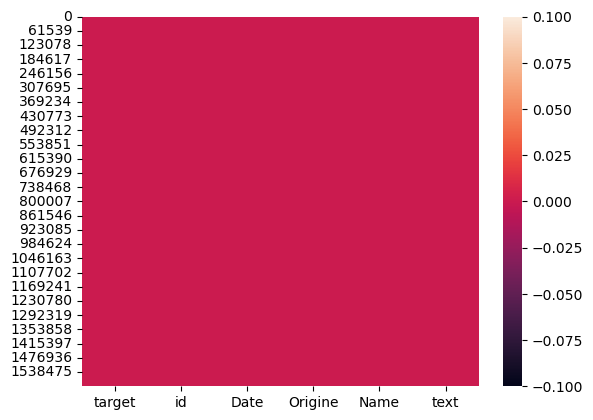

In [5]:
sns.heatmap(df.isnull());

In [6]:
df = df[['id','target','text']]
df

,id,target,text
0,1467810369,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,1467810672,0,is upset that he can't update his Facebook by ...
2,1467810917,0,@Kenichan I dived many times for the ball. Man...
3,1467811184,0,my whole body feels itchy and like its on fire
4,1467811193,0,"@nationwideclass no, it's not behaving at all...."
...,...,...,...
1599995,2193601966,4,Just woke up. Having no school is the best fee...
1599996,2193601969,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,2193601991,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,2193602064,4,Happy 38th Birthday to my boo of alll time!!! ...


In [7]:
df.target.unique()

array([0, 4], dtype=int64)

In [8]:
df.loc[df['target'] == 4, 'target'] = 1
df.target.unique()

array([0, 1], dtype=int64)

In [9]:
df['target'].sample(20)

1036164    1
360517     0
1036771    1
1295124    1
791781     0
625899     0
59901      0
503851     0
1585290    1
284336     0
1250465    1
1533222    1
427412     0
1085925    1
1116213    1
683021     0
202508     0
1456172    1
1197179    1
1481212    1
Name: target, dtype: int64

In [10]:
category_count = df['target'].value_counts()
category_count

target
0    800000
1    800000
Name: count, dtype: int64

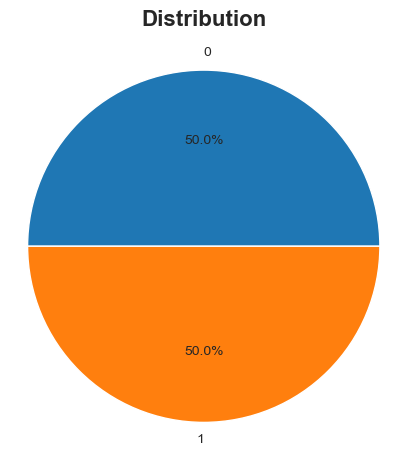

In [11]:
# La distribution par categorie
plt.figure(figsize=(5, 5))
sns.set_style("whitegrid")
plt.pie(category_count, labels=category_count.index, autopct='%1.1f%%')
plt.title('Distribution',  fontsize=16, fontweight='bold', pad=20)
plt.axis('equal') 
plt.show()

#### La distribution est pafaitement équilibrée

In [12]:
# Sélectionner aléatoirement 10 000 tweets positifs
tweets_positifs = df[df['target'] == 1].sample(n=10000, random_state=42, replace=True)

# Sélectionner aléatoirement 10 000 tweets négatifs
tweets_negatifs = df[df['target'] == 0].sample(n=10000, random_state=42, replace=True)

# Concaténer les tweets positifs et négatifs sélectionnés
df_select = pd.concat([tweets_positifs, tweets_negatifs])

# Réinitialiser les index
df_select = df_select.reset_index(drop=True)
df_select


,id,target,text
0,1754307909,1,"@V_J I haven't been sleeping well this wk, had..."
1,2065164963,1,okay off to sleep now
2,1770953638,1,@ashlili LIKE MEEEEEEEEE
3,1979880815,1,@Eva_Abreu Maybe we're bored..lol..I got plent...
4,1963116716,1,yay for atwin who had her baby boy Matthew Joh...
...,...,...,...
19995,1687823873,0,sick from last night D: sore throat and a bitt...
19996,2215673652,0,@devilgossip everything is picked over.
19997,1975039952,0,@alyssabuonagura josh's party. I was stupid an...
19998,1692881944,0,@MixedByAli thats dope..yea im bout to hit the...


In [13]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

nltk.download('stopwords')
nltk.download('punkt')


def clean_text(text):
    # Suppression des caractères spéciaux et de la ponctuation
    text = re.sub(r"[^\w\s]", "", text)
    
    # Conversion en minuscules
    text = text.lower()
    
    # Tokenisation du texte
    tokens = word_tokenize(text)
    
    # Suppression des mots vides
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Joindre les tokens en une seule chaîne
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text


# Appliquer le nettoyage du texte sur la colonne 'texte'
df_select['text_clean'] = df_select['text'].apply(clean_text)

df=df_select

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
df

,id,target,text,text_clean
0,1754307909,1,"@V_J I haven't been sleeping well this wk, had...",v_j havent sleeping well wk gig fri nite amp w...
1,2065164963,1,okay off to sleep now,okay sleep
2,1770953638,1,@ashlili LIKE MEEEEEEEEE,ashlili like meeeeeeeee
3,1979880815,1,@Eva_Abreu Maybe we're bored..lol..I got plent...,eva_abreu maybe boredloli got plenty sleep fel...
4,1963116716,1,yay for atwin who had her baby boy Matthew Joh...,yay atwin baby boy matthew john last night 8 l...
...,...,...,...,...
19995,1687823873,0,sick from last night D: sore throat and a bitt...,sick last night sore throat bitt congested fri...
19996,2215673652,0,@devilgossip everything is picked over.,devilgossip everything picked
19997,1975039952,0,@alyssabuonagura josh's party. I was stupid an...,alyssabuonagura joshs party stupid left table ...
19998,1692881944,0,@MixedByAli thats dope..yea im bout to hit the...,mixedbyali thats dopeyea im bout hit sheetswork


In [15]:
df_select

,id,target,text,text_clean
0,1754307909,1,"@V_J I haven't been sleeping well this wk, had...",v_j havent sleeping well wk gig fri nite amp w...
1,2065164963,1,okay off to sleep now,okay sleep
2,1770953638,1,@ashlili LIKE MEEEEEEEEE,ashlili like meeeeeeeee
3,1979880815,1,@Eva_Abreu Maybe we're bored..lol..I got plent...,eva_abreu maybe boredloli got plenty sleep fel...
4,1963116716,1,yay for atwin who had her baby boy Matthew Joh...,yay atwin baby boy matthew john last night 8 l...
...,...,...,...,...
19995,1687823873,0,sick from last night D: sore throat and a bitt...,sick last night sore throat bitt congested fri...
19996,2215673652,0,@devilgossip everything is picked over.,devilgossip everything picked
19997,1975039952,0,@alyssabuonagura josh's party. I was stupid an...,alyssabuonagura joshs party stupid left table ...
19998,1692881944,0,@MixedByAli thats dope..yea im bout to hit the...,mixedbyali thats dopeyea im bout hit sheetswork


In [16]:
import re, nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
def cleaned_text(text):
    clean = re.sub("\n"," ",text)
    clean=clean.lower()
    clean=re.sub(r"[~.,%/:;?_&+*=!-]"," ",clean)
    clean=re.sub("[^a-z]"," ",clean)
    clean=clean.lstrip()
    clean=re.sub("\s{2,}"," ",clean)
    return clean
df["cleaned_text"]=df["text"].apply(cleaned_text)

In [18]:
df["cleaned_text"].head(10)

0    v j i haven t been sleeping well this wk had a...
1                               okay off to sleep now 
2                             ashlili like meeeeeeeee 
3    eva abreu maybe we re bored lol i got plenty o...
4    yay for atwin who had her baby boy matthew joh...
5    tungly haha thanks tung would rather not end u...
6    if you are a cute guy add follow me i ll do th...
7    drinking a smoothy nothing tastes better after...
8    i need the code to text facebook to the first ...
9    antandbecks hey could you guys play a song for...
Name: cleaned_text, dtype: object

In [19]:
df["cleaned_text"] = df["cleaned_text"].apply(lambda x: ' '.join([word for word in x.split() if len(word)>3]))

In [20]:
df["cleaned_text"].head(10)

0    haven been sleeping well this nite woke early ...
1                                           okay sleep
2                              ashlili like meeeeeeeee
3    abreu maybe bored plenty sleep fell asleep wat...
4            atwin baby matthew john last night ounces
5    tungly haha thanks tung would rather with meal...
6                                     cute follow same
7    drinking smoothy nothing tastes better after r...
8                 need code text facebook first person
9    antandbecks could guys play song requested col...
Name: cleaned_text, dtype: object

In [21]:
df

,id,target,text,text_clean,cleaned_text
0,1754307909,1,"@V_J I haven't been sleeping well this wk, had...",v_j havent sleeping well wk gig fri nite amp w...,haven been sleeping well this nite woke early ...
1,2065164963,1,okay off to sleep now,okay sleep,okay sleep
2,1770953638,1,@ashlili LIKE MEEEEEEEEE,ashlili like meeeeeeeee,ashlili like meeeeeeeee
3,1979880815,1,@Eva_Abreu Maybe we're bored..lol..I got plent...,eva_abreu maybe boredloli got plenty sleep fel...,abreu maybe bored plenty sleep fell asleep wat...
4,1963116716,1,yay for atwin who had her baby boy Matthew Joh...,yay atwin baby boy matthew john last night 8 l...,atwin baby matthew john last night ounces
...,...,...,...,...,...
19995,1687823873,0,sick from last night D: sore throat and a bitt...,sick last night sore throat bitt congested fri...,sick from last night sore throat bitt congeste...
19996,2215673652,0,@devilgossip everything is picked over.,devilgossip everything picked,devilgossip everything picked over
19997,1975039952,0,@alyssabuonagura josh's party. I was stupid an...,alyssabuonagura joshs party stupid left table ...,alyssabuonagura josh party stupid left table n...
19998,1692881944,0,@MixedByAli thats dope..yea im bout to hit the...,mixedbyali thats dopeyea im bout hit sheetswork,mixedbyali thats dope bout sheets work


In [22]:
df['cleaned_text']

0        haven been sleeping well this nite woke early ...
1                                               okay sleep
2                                  ashlili like meeeeeeeee
3        abreu maybe bored plenty sleep fell asleep wat...
4                atwin baby matthew john last night ounces
                               ...                        
19995    sick from last night sore throat bitt congeste...
19996                   devilgossip everything picked over
19997    alyssabuonagura josh party stupid left table n...
19998               mixedbyali thats dope bout sheets work
19999         peterfacinelli really hope dont disappointed
Name: cleaned_text, Length: 20000, dtype: object

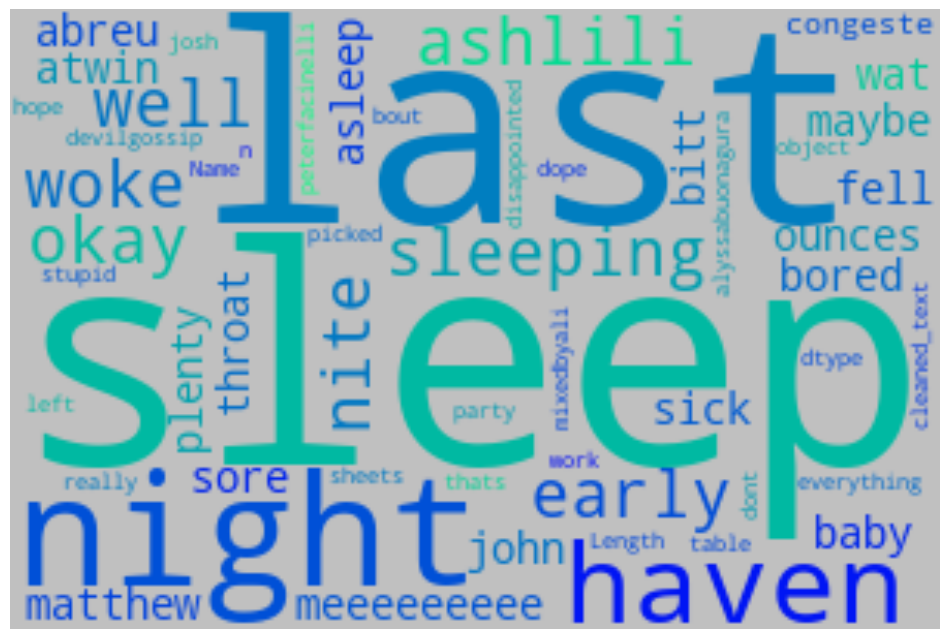

In [23]:
cloud=WordCloud(background_color='silver', colormap="winter", width=300,height=200).generate(str(df["cleaned_text"]))
fig=plt.figure(figsize=(12,9))
plt.axis("off")
plt.imshow(cloud,interpolation='bilinear');

In [24]:
stop=stopwords.words('english')
stop.append("also")
df["stop_cleaned_text"]=df["cleaned_text"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [25]:
from nltk.tokenize import word_tokenize
df["tokenized"]=df["stop_cleaned_text"].apply(lambda x: nltk.word_tokenize(x))

In [26]:
df["tokenized"]

0        [sleeping, well, nite, woke, early, sleep, tim...
1                                            [okay, sleep]
2                              [ashlili, like, meeeeeeeee]
3        [abreu, maybe, bored, plenty, sleep, fell, asl...
4        [atwin, baby, matthew, john, last, night, ounces]
                               ...                        
19995    [sick, last, night, sore, throat, bitt, conges...
19996                    [devilgossip, everything, picked]
19997    [alyssabuonagura, josh, party, stupid, left, t...
19998        [mixedbyali, thats, dope, bout, sheets, work]
19999    [peterfacinelli, really, hope, dont, disappoin...
Name: tokenized, Length: 20000, dtype: object

In [27]:
from nltk.stem import WordNetLemmatizer

In [28]:
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i,pos='v') for i in text]
    return lem_text
df["lemmatized"]=df["tokenized"].apply(lambda x: word_lemmatizer(x))
df["lemmatize_joined"]=df["lemmatized"].apply(lambda x: ' '.join(x))

In [29]:
df["lemmatize_joined"].head()

0          sleep well nite wake early sleep time crash
1                                           okay sleep
2                              ashlili like meeeeeeeee
3    abreu maybe bore plenty sleep fell asleep watc...
4            atwin baby matthew john last night ounces
Name: lemmatize_joined, dtype: object

In [30]:
df["lemmatize_joined"]

0              sleep well nite wake early sleep time crash
1                                               okay sleep
2                                  ashlili like meeeeeeeee
3        abreu maybe bore plenty sleep fell asleep watc...
4                atwin baby matthew john last night ounces
                               ...                        
19995    sick last night sore throat bitt congest frien...
19996                          devilgossip everything pick
19997    alyssabuonagura josh party stupid leave table ...
19998                mixedbyali thats dope bout sheet work
19999           peterfacinelli really hope dont disappoint
Name: lemmatize_joined, Length: 20000, dtype: object

In [31]:
df_samp = df.sample(10)


In [32]:
for idx, ser in df_samp.iterrows():
    id_prod = f": {ser['id']}\n"
    print( id_prod + ser["lemmatize_joined"]+ "..." +"\n\n")

: 1979680932
back dinner...


: 1881317857
leedsjjo start thurs june less weeks lot show aswell hold know...


: 1970940812
get bore saturday life...


: 2175326586
good morningggg...


: 1986083420
almost adopt today http twitpic djzz...


: 2213404246
ktsummer sorry hear hope everything work best family prayers...


: 1999471620
free phone card http fkhva...


: 1967888249
shiaomei quot sugardoggy make great music together http blip aukk...


: 1573632178
tattoo mummy thank...


: 1792535108
wait hand snow leopard boot camp drivers windows read drive probably mean filesystem...




###  Transformers

## word2vec

In [57]:
import multiprocessing
from gensim.models import FastText
from gensim.test.utils import common_texts 

In [58]:
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings 
warnings.filterwarnings(action='ignore')
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

In [59]:
dfsamp_vec =df.sample(1000)
df= dfsamp_vec[['lemmatize_joined','target']]

In [60]:
sentenses = [word_tokenize(rev.lower()) for rev in df.lemmatize_joined]

In [61]:
model= FastText(sentenses, vector_size=100, window= 5, min_count=1, workers=4, seed = 4, sg=1  )

In [62]:
ftext = model.wv

In [ ]:
# Création d'une liste des phrases 
sentences = df.lemmatize_joined.tolist()
# Entraînement du modèle 
model = FastText(sentenses, vector_size=100, window= 5, min_count=1, workers=4, seed = 4, sg=1  )
# stocker les vecteurs de phrases
sentence_vectors = []
# Boucle des phrases
for sentence in sentences:
    sentence_vector = []
    # Parcourir chaque mot de la phrase et obtenir son vecteur
    for word in sentence:
        if word in model.wv:
            sentence_vector.append(model.wv[word])
    # Calculer le vecteur moyen de la phrase
    if sentence_vector:
        mean_vector = np.mean(sentence_vector, axis=0)
        sentence_vectors.append(mean_vector)

# Création d'un DataFrame à partir des vecteurs obtenus
df_sentence_vectors = pd.DataFrame(sentence_vectors, index=df['lemmatize_joined'],
                                   columns=[f'feature_{i+1}' for i in range(100)])

In [56]:
from sklearn.manifold import TSNE

In [53]:
len(sentence_vectors)

998

In [57]:
# Defining the t-SNE 
n_components = 2
tsne = TSNE(n_components = n_components)

# Fitting to the word_vectors_df
tsne_result_wv = tsne.fit_transform(df_sentence_vectors)

# Create a new DataFrame for the t-SNE results
df_tsne_wv = pd.DataFrame(data = tsne_result_wv, columns = ["TSNE{}".format(i+1) for i in range(n_components)])

In [58]:
df_tsne_wv

,TSNE1,TSNE2
0,-0.027021,-0.944104
1,1.015510,0.537327
2,-10.029070,-12.148231
3,12.548967,-1.489838
4,11.429246,-10.911567
...,...,...
993,28.629496,1.304003
994,-26.300419,-4.649808
995,12.070882,13.895082
996,14.018435,-3.158083


In [39]:
from sklearn.preprocessing import LabelEncoder

In [40]:
label_encoder = LabelEncoder()

# Fit and transform the 'category' column
dfsamp_vec['target_encod'] = label_encoder.fit_transform(dfsamp_vec['target'])

In [41]:
model1 = gensim.models.Word2Vec(dfsamp_vec.lemmatize_joined, min_count=1,
                                vector_size=100, window=5)

## BERT (Bidirectional Encoder Representations from Transformers)¶

In [45]:
df

,index,target,text,cleaned_text,stop_cleaned_text,tokenized,lemmatized,lemmatize_joined
714744,714744,0,Can you be in love with your ipod? Cuz I think...,love with your ipod think love with mine cept ...,love ipod think love mine cept youtube still w...,"[love, ipod, think, love, mine, cept, youtube,...","[love, ipod, think, love, mine, cept, youtube,...",love ipod think love mine cept youtube still w...
605475,605475,0,Stunning Defeat - I (2245) was beaten by HIRUS...,stunning defeat beaten hirushaka,stunning defeat beaten hirushaka,"[stunning, defeat, beaten, hirushaka]","[stun, defeat, beat, hirushaka]",stun defeat beat hirushaka
992094,992094,1,"So glad Dave didn't kill MJ, Wow! Lynette preg...",glad dave didn kill lynette preggers with twin...,glad dave kill lynette preggers twins wait dan...,"[glad, dave, kill, lynette, preggers, twins, w...","[glad, dave, kill, lynette, preggers, twin, wa...",glad dave kill lynette preggers twin wait danc...
271487,271487,0,@smosh For a second there i thought you said B...,smosh second there thought said burrito making...,smosh second thought said burrito making movie...,"[smosh, second, thought, said, burrito, making...","[smosh, second, think, say, burrito, make, mov...",smosh second think say burrito make movie diss...
866051,866051,1,i am learning with piczo.com and twitter.com,learning with piczo twitter,learning piczo twitter,"[learning, piczo, twitter]","[learn, piczo, twitter]",learn piczo twitter
...,...,...,...,...,...,...,...,...
896256,896256,1,lol @by_starla with regards to the furballs. ...,starla with regards furballs mine usually like...,starla regards furballs mine usually like real...,"[starla, regards, furballs, mine, usually, lik...","[starla, regard, furballs, mine, usually, like...",starla regard furballs mine usually like reall...
1412161,1412161,1,At the zoo to look at lizards.,look lizards,look lizards,"[look, lizards]","[look, lizards]",look lizards
870724,870724,1,"oh im bored, but i got my Tap Exam Slip today,...",bored exam slip today sarah wehey need more exams,bored exam slip today sarah wehey need exams,"[bored, exam, slip, today, sarah, wehey, need,...","[bore, exam, slip, today, sarah, wehey, need, ...",bore exam slip today sarah wehey need exams
1468545,1468545,1,Looking forward to brunch,looking forward brunch,looking forward brunch,"[looking, forward, brunch]","[look, forward, brunch]",look forward brunch


In [46]:
df.shape

(20000, 8)

In [47]:
df_lem_bert = df.sample(2000)

In [48]:
df_lem_bert

,index,target,text,cleaned_text,stop_cleaned_text,tokenized,lemmatized,lemmatize_joined
1370148,1370148,1,I'm guessing @cyclingfansanon is feeling a lit...,guessing cyclingfansanon feeling little extra ...,guessing cyclingfansanon feeling little extra ...,"[guessing, cyclingfansanon, feeling, little, e...","[guess, cyclingfansanon, feel, little, extra, ...",guess cyclingfansanon feel little extra frisky...
606079,606079,0,I had a very bad dream last night.,very dream last night,dream last night,"[dream, last, night]","[dream, last, night]",dream last night
166020,166020,0,@kdc well there go my peace corps prospects.,well there peace corps prospects,well peace corps prospects,"[well, peace, corps, prospects]","[well, peace, corps, prospect]",well peace corps prospect
869050,869050,1,LOL NOW I MADE THIS ACCOUNT WAT DO I DO lol BO...,made this account bored hiiii elen again,made account bored hiiii elen,"[made, account, bored, hiiii, elen]","[make, account, bore, hiiii, elen]",make account bore hiiii elen
1316451,1316451,1,"@jhenvee oooh! what kind? yes, ofcourse ima be...",jhenvee oooh what kind ofcourse there wish kno...,jhenvee oooh kind ofcourse wish know make well...,"[jhenvee, oooh, kind, ofcourse, wish, know, ma...","[jhenvee, oooh, kind, ofcourse, wish, know, ma...",jhenvee oooh kind ofcourse wish know make well...
...,...,...,...,...,...,...,...,...
1485915,1485915,1,Looking good for keeping out the BNP in NW #eu09,looking good keeping,looking good keeping,"[looking, good, keeping]","[look, good, keep]",look good keep
904611,904611,1,omg supernatural is on after good news week,supernatural after good news week,supernatural good news week,"[supernatural, good, news, week]","[supernatural, good, news, week]",supernatural good news week
867825,867825,1,just had a very nice dinner at xin wang with m...,just very nice dinner wang with dear family ce...,nice dinner wang dear family celebrate bday,"[nice, dinner, wang, dear, family, celebrate, ...","[nice, dinner, wang, dear, family, celebrate, ...",nice dinner wang dear family celebrate bday
971366,971366,1,"http://twitpic.com/5envv - Ohh yaa man ,, It's...",http twitpic envv suummer quebbec speak french,http twitpic envv suummer quebbec speak french,"[http, twitpic, envv, suummer, quebbec, speak,...","[http, twitpic, envv, suummer, quebbec, speak,...",http twitpic envv suummer quebbec speak french


In [49]:
import torch
from transformers import BertTokenizer, BertModel

In [50]:
# Setting the device to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Setting the model to evaluation mode
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [51]:
# Fonction pour encoder le texte à l'aide du tokenizer
def get_bert_embeddings(text):
    encoded_input = tokenizer(text, padding = True, truncation = True, return_tensors = 'pt')
    input_ids = encoded_input['input_ids'].to(device)
    attention_mask = encoded_input['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask = attention_mask)
        
    # Calculating the mean embedding of the last hidden state
    embeddings = outputs.last_hidden_state.mean(dim = 1)
    
    # Converting the embeddings to a list and return
    return embeddings.tolist()[0]

In [52]:
# Applying the function to the lemmatized text
df_bert = df_lem_bert['lemmatize_joined'].apply(get_bert_embeddings)

In [53]:
df_bert_fin = pd.DataFrame(df_bert)

In [54]:
df_bert_fin.head()

,lemmatize_joined
1370148,"[0.03950053080916405, -0.2665681838989258, 0.6..."
606079,"[0.30222830176353455, -0.4306241571903229, 0.3..."
166020,"[0.22930948436260223, 0.03237859532237053, -0...."
869050,"[0.05824290215969086, 0.1249835193157196, 0.18..."
1316451,"[-0.1750033050775528, 0.18008284270763397, 0.6..."


In [55]:
# Transforming to a list
df_bert_list = pd.DataFrame(df_bert_fin['lemmatize_joined'].to_list())

# Splitting the values within the columns using comma delimiter
df_bert_conc = pd.concat([df_bert_list[col].astype(str).str.split(',', expand=True) for col in df_bert_list.columns], axis=1)

# Renaming columns starting from 0
df_bert_conc.columns = [str(i) for i in range(len(df_bert_conc.columns))]

# Displaying the resulting DataFrame with separate columns
df_bert_conc

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.03950053080916405,-0.2665681838989258,0.66170334815979,0.08908633887767792,0.035370271652936935,-0.031025845557451248,0.2766518294811249,0.18902702629566193,-0.17754150927066803,-0.15181082487106323,...,0.010125730186700821,-0.04450138658285141,-0.032056596130132675,-0.21449948847293854,0.030510399490594864,0.20952357351779938,-0.23981724679470062,-0.12861832976341248,-0.1173086166381836,0.12213266640901566
1,0.30222830176353455,-0.4306241571903229,0.37565022706985474,0.00347331166267395,-0.15570911765098572,-0.5526053309440613,0.1766146719455719,0.526577353477478,0.040775932371616364,-0.4514384865760803,...,0.09801328182220459,0.10386469215154648,0.5544208288192749,-0.7113872766494751,0.34283843636512756,0.46593135595321655,0.18339817225933075,-0.36462047696113586,-0.0875949114561081,-0.4967438578605652
2,0.22930948436260223,0.03237859532237053,-0.15993253886699677,-0.03081248141825199,0.1418416053056717,-0.24415190517902374,0.39405810832977295,0.05126577615737915,-0.5205243825912476,-0.06873328238725662,...,0.27127036452293396,-0.38684403896331787,0.011665304191410542,-0.2588164806365967,0.26396387815475464,0.035158395767211914,-0.15213468670845032,0.1819874495267868,-0.05009770393371582,-0.112678162753582
3,0.05824290215969086,0.1249835193157196,0.18403805792331696,-0.4307049810886383,-0.047836657613515854,-0.16591058671474457,0.0552452951669693,0.15743614733219147,0.011461423709988594,-0.40326055884361267,...,0.30203044414520264,-0.3434187173843384,-0.1404007524251938,0.07142281532287598,0.038901589810848236,0.2328217774629593,-0.14596329629421234,-0.06988591700792313,0.1375892013311386,0.13309718668460846
4,-0.1750033050775528,0.18008284270763397,0.6812730431556702,-0.10987941920757294,0.3485897183418274,-0.4773307740688324,0.26190435886383057,0.3064843714237213,-0.0625913143157959,-0.31829509139060974,...,-0.16039757430553436,-0.725387692451477,-0.15325164794921875,-0.09606228023767471,-0.35130688548088074,0.13029024004936218,0.04910476505756378,-0.3174324631690979,0.014977000653743744,0.2818079888820648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.42699018120765686,-0.27448081970214844,-0.028633862733840942,-0.06629295647144318,0.3499208390712738,-0.1363414227962494,0.22325968742370605,0.16749045252799988,0.19906523823738098,-0.41925424337387085,...,0.13106361031532288,-0.2142440527677536,0.18022248148918152,-0.2807433307170868,-0.17721278965473175,0.11549307405948639,-0.19910497963428497,-0.12000767886638641,-0.2894676923751831,-0.4617304801940918
1996,0.34699949622154236,-0.30587849020957947,0.029126614332199097,0.052811622619628906,0.18517418205738068,-0.5496090054512024,0.7347576022148132,0.6692371368408203,-0.1801333874464035,-0.40333035588264465,...,0.020688071846961975,-0.014041237533092499,0.13332553207874298,-0.36967453360557556,-0.14582736790180206,0.06729588657617569,-0.02804393321275711,-0.023054027929902077,0.1820722371339798,-0.3951553404331207
1997,0.1655435860157013,-0.11037617921829224,0.8183673620223999,-0.3182448744773865,-0.22447554767131805,-0.32056838274002075,0.3084529936313629,0.5728680491447449,-0.12666946649551392,-0.2878855764865875,...,-0.04213627800345421,-0.10337531566619873,0.0848296657204628,0.018459612503647804,-0.08052308857440948,0.06467324495315552,0.12574881315231323,-0.38483333587646484,-0.14196941256523132,-0.20868965983390808
1998,0.02011346071958542,0.004686082247644663,0.15318942070007324,-0.2620755732059479,0.06024548038840294,-0.17110329866409302,0.3111446797847748,0.5541794300079346,-0.11116001009941101,-0.3549443185329437,...,0.21442797780036926,-0.21548601984977722,-0.18513363599777222,-0.6444903016090393,0.06221739575266838,0.18941837549209595,-0.20596426725387573,-0.14212331175804138,0.16037391126155853,0.3122631311416626


In [56]:
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score

In [57]:
# Defining the t-SNE 
n_components = 2
tsne = TSNE(n_components = n_components)

# Fitting to the df_tfidf
tsne_result_bert = tsne.fit_transform(df_bert_conc)

# Creating a new df for the results
df_tsne_bert = pd.DataFrame(data = tsne_result_bert, columns = ["TSNE{}".format(i+1) for i in range(n_components)])

In [58]:
label_encoder = LabelEncoder()

# Fit and transform the 'category' column
df_lem_bert['Target_encod'] = label_encoder.fit_transform(df_lem_bert['target'])

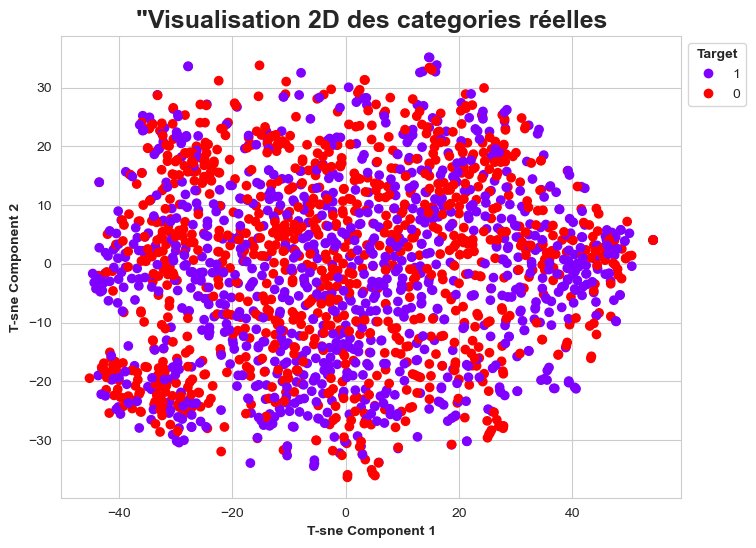

In [59]:
# Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(df_tsne_bert['TSNE1'], df_tsne_bert['TSNE2'], c=df_lem_bert['Target_encod'], cmap='Accent_r')

# Adding a legend based on the 'category' column
handles, labels = scatter.legend_elements()
legend = plt.legend(handles, df_lem_bert['Target_encod'].unique(), title='Target', bbox_to_anchor=(1,1), loc='upper left')
legend.get_title().set_fontweight('bold')

# Adding details 
plt.xlabel('T-sne Component 1', fontweight = 'bold')
plt.ylabel('T-sne Component 2', fontweight = 'bold')
plt.title('"Visualisation 2D des categories réelles', fontweight ='bold', fontsize=18)
plt.show()

In [60]:
# NLP
import nltk
nltk.download('wordnet')
import re
from textblob import TextBlob
from sklearn.feature_extraction import text
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
# Machine Learning
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [61]:
# Getting a count of words from the documents
# Ngram_range is set to 1,2 - meaning either single or two word combination will be extracted
tokenizer = TweetTokenizer()
cvec = CountVectorizer(ngram_range=(1,2), tokenizer=tokenizer.tokenize)
full_text = list(df["lemmatize_joined"].values)
cvec.fit(full_text)
# Getting the total n-gram count
len(cvec.vocabulary_)

111023

In [62]:
train_vectorized = cvec.transform(df["lemmatize_joined"])

# Getting the matrix shape
print('sparse matrix shape:', train_vectorized.shape)

# Getting the nonzero count
print('nonzero count:', train_vectorized.nnz)

# Getting sparsity %
print('sparsity: %.2f%%' % (100.0 * train_vectorized.nnz / (train_vectorized.shape[0] * train_vectorized.shape[1])))

sparse matrix shape: (20000, 111023)
nonzero count: 226617
sparsity: 0.01%


In [63]:
test_vectorized = cvec.transform(df["lemmatize_joined"])

# Getting the matrix shape
print('sparse matrix shape:', test_vectorized.shape)

# Getting the nonzero count
print('nonzero count:', test_vectorized.nnz)

# Getting sparsity %
print('sparsity: %.2f%%' % (100.0 * test_vectorized.nnz / (test_vectorized.shape[0] * test_vectorized.shape[1])))

sparse matrix shape: (20000, 111023)
nonzero count: 226617
sparsity: 0.01%


In [64]:
test_vectorized 

<20000x111023 sparse matrix of type '<class 'numpy.int64'>'
	with 226617 stored elements in Compressed Sparse Row format>

In [65]:
transformer = TfidfTransformer()

# Fitting and transforming n-grams
train_tdidf = transformer.fit_transform(train_vectorized)
test_tdidf = transformer.fit_transform(test_vectorized)

In [66]:
# Create X & y variables for Machine Learning
X_train = train_tdidf
y_train = df['target']

X_test = test_tdidf

In [67]:
def model(mod, model_name, X_train, y_train):
    
    # Fitting model
    mod.fit(X_train, y_train)
    
    # Print model name
    print(model_name)
    
    # Compute 5-fold cross validation: Accuracy
    acc = cross_val_score(mod, X_train, y_train, scoring = "accuracy", cv = 5)

    # Compute 5-fold prediction on training set
    predictions = cross_val_predict(mod, X_train, y_train, cv = 5)

    # Return accuracy score to 3dp
    print("Accuracy:", round(acc.mean(), 3))
 
    # Compute confusion matrix
    cm = confusion_matrix(predictions, y_train)
    
    # Print confusion matrix
    print("Confusion Matrix:  \n", cm)

    # Print classification report
    print("Classification Report \n", classification_report(predictions, y_train))

## USE (Universal Sentence Encoder)

In [ ]:
dfsamp_vec =df.sample(1000)
df= dfsamp_vec[['lemmatize_joined','target']]

In [71]:
df

,lemmatize_joined,target
1499913,finally totally knackered night peep,1
1324155,alexandramusic mornin alex look abit breezy ou...,1
61640,home sick baby sick hubby,0
574995,room mess pretend binder take care work,0
1498208,koreekreeper go watch do watch comedian stoke,1
...,...,...
230371,kaylaanic damn miss,0
1211746,partywithneha tweet tip suddentwilight feature...,1
583004,sleep know go struggle,0
1385587,egyptsaidso followers use tweeteradder everyon...,1


In [73]:
import tensorflow as tf

In [69]:
import tensorflow_hub as hub

In [74]:
#Converting each sequence of words into a single string
sentences = df['lemmatize_joined'].apply(' '.join).values.astype('U')

# Getting and loading the URL for the USE model
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"
use_model = hub.load(module_url)

# Creating a KerasLayer fro mthe loaded model
embedding_fn = hub.KerasLayer(use_model, input_shape=[], dtype=tf.string, trainable=False)

# Creating a sequential model with the embedding layer
embedding_model = tf.keras.Sequential([embedding_fn])

# Converting the sentences to a numpy array
sentences_array = np.array(sentences, dtype=object) 

# Generating the sentences with the embedding model
embeddings = embedding_model.predict(sentences_array)

# Transforming to df
df_embed = pd.DataFrame(embeddings)

32/32 [==============================] - 86s 2s/step


In [75]:
embedding_df

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,-0.035763,-0.007263,-0.015313,0.021980,-0.004596,0.016863,-0.006837,-0.041138,0.011714,-0.019389,...,-0.028231,-0.004539,0.006494,0.003904,-0.027112,-0.094967,0.026416,-0.015127,-0.009010,-0.003603
1,-0.042543,0.007733,-0.019665,0.049731,-0.015267,-0.015008,0.004350,-0.048169,0.008262,-0.029242,...,-0.040083,0.004062,0.025400,-0.001784,-0.035852,-0.085054,0.001270,-0.015406,0.014123,-0.009762
2,-0.017520,-0.001559,-0.025006,0.018224,-0.024273,0.002357,0.008080,-0.083848,-0.012854,-0.012273,...,-0.049052,-0.025622,-0.016247,-0.016237,0.001236,-0.027342,0.009918,0.001267,-0.008302,0.004202
3,-0.062091,-0.012830,-0.022485,0.043848,-0.030246,-0.024908,-0.007248,-0.050628,0.019576,-0.024141,...,-0.029607,-0.007581,0.008077,-0.013906,-0.042690,-0.060600,0.013275,-0.001411,0.009681,-0.005721
4,-0.027573,-0.007272,-0.020073,0.031407,-0.036571,0.008009,0.002422,-0.053384,0.016390,-0.021443,...,-0.025905,-0.009973,0.017918,-0.019224,-0.026152,-0.080431,0.018709,-0.000223,0.012344,0.000185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.033309,-0.014630,-0.027958,0.035373,0.014308,-0.027436,0.002492,-0.058117,0.016648,-0.025126,...,-0.060033,-0.019367,-0.010988,0.005318,-0.012127,-0.082948,0.043657,-0.014115,-0.017783,0.004280
996,-0.026321,-0.000615,-0.022509,0.028718,-0.013586,0.018289,0.005473,-0.043590,0.018148,-0.026491,...,-0.020713,-0.013282,0.016384,-0.018465,-0.038492,-0.096688,0.019851,0.033745,0.034044,-0.007049
997,-0.045078,0.002351,0.000041,0.029676,-0.039266,0.006017,-0.006557,-0.042397,0.007800,-0.006715,...,-0.024176,-0.021558,0.011939,-0.037888,-0.026386,-0.072525,0.001232,-0.017845,0.019030,0.013849
998,-0.047006,-0.012782,-0.009291,0.028817,-0.022258,-0.017074,-0.015166,-0.042204,0.011793,-0.025107,...,-0.017267,0.002151,0.020183,-0.017519,-0.044303,-0.096073,0.008644,0.001660,0.031089,-0.004990


In [76]:
n_components = 2
tsne = TSNE(n_components = n_components)

# Fitting to the df_tfidf
tsne_result_use = tsne.fit_transform(embedding_df)

# Create a new DataFrame for the t-SNE results
df_tsne_use = pd.DataFrame(data = tsne_result_use, columns = ["TSNE{}".format(i+1) for i in range(n_components)])

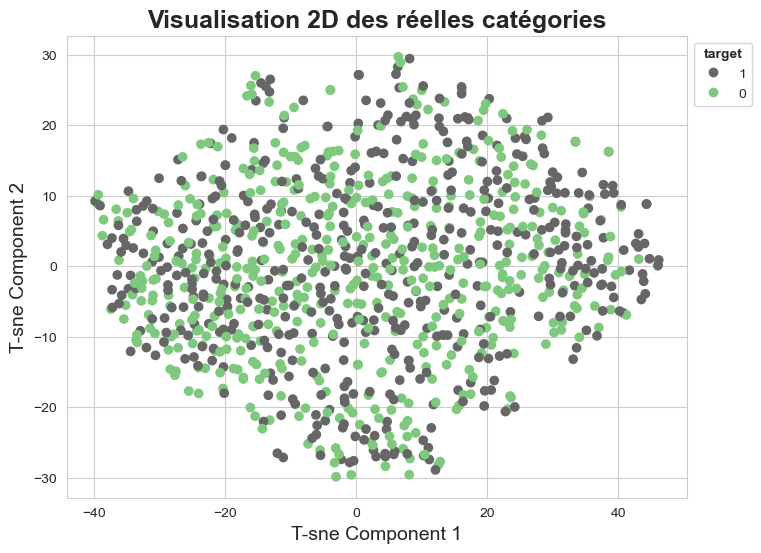

In [93]:
# Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(df_tsne_use['TSNE1'], df_tsne_use['TSNE2'], c=df['target'], cmap='Accent_r')

# Adding a legend based on the 'category' column
handles, labels = scatter.legend_elements()
legend = plt.legend(handles, df['target'].unique(), title='target', bbox_to_anchor=(1,1), loc='upper left')
legend.get_title().set_fontweight('bold')

# Adding details 
plt.xlabel('T-sne Component 1', fontsize=14)
plt.ylabel('T-sne Component 2', fontsize=14)
plt.title('Visualisation 2D des réelles catégories', fontweight ='bold', fontsize=18)
plt.show()

## Modelisation

In [33]:
from joblib import dump 
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Créer une instance du vectoriseur TfidfVectorizer
vectorizer = TfidfVectorizer()

# Appliquer le vectoriseur sur la colonne 'texte_nettoye'
features = vectorizer.fit_transform(df["lemmatize_joined"])

# Convertir les caractéristiques en une représentation de matrice creuse
features = features.toarray()

# Afficher les dimensions de la matrice de caractéristiques
print("Dimensions de la matrice de caractéristiques :", features.shape)

Dimensions de la matrice de caractéristiques : (20000, 24103)


In [36]:
features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [35]:
from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test de façon stratifiée
X_train, X_test, y_train, y_test = train_test_split(features, df['target'], test_size=0.2, stratify=df['target'], random_state=42)

### LogisticRegression

In [37]:
# Construire le modèle de régression logistique
reg_model = LogisticRegression()
reg_model.fit(X_train, y_train)

# Prédire les probabilités pour les ensembles d'entraînement et de test
y_train_pred = reg_model.predict_proba(X_train)[:, 1]
y_test_pred = reg_model.predict_proba(X_test)[:, 1]


In [38]:
print(reg_model.score(X_train, y_train ))
print(reg_model.score(X_test, y_test ))

0.8563125
0.72525


In [39]:
y_pred = reg_model.predict(X_test)

In [40]:
accuracy_score(y_test, y_pred)

0.72525

In [41]:
dump(reg_model, 'reg_model.joblib')

['reg_model.joblib']

In [42]:


# Calculer les valeurs de la courbe ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

# Calculer l'AUC pour les ensembles d'entraînement et de test
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)


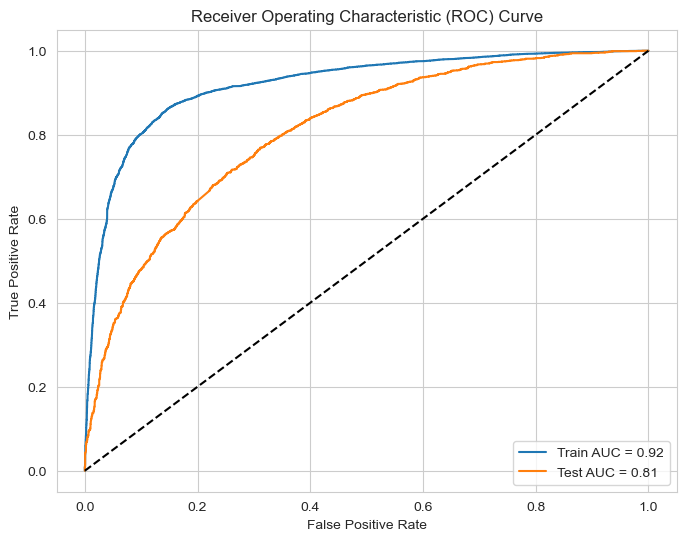

In [43]:
# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label='Train AUC = {:.2f}'.format(auc_train))
plt.plot(fpr_test, tpr_test, label='Test AUC = {:.2f}'.format(auc_test))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [63]:
# Calculer les performances sur les ensembles d'entraînement et de test
train_accuracy = accuracy_score(y_train, reg_model.predict(X_train))
train_precision = precision_score(y_train, reg_model.predict(X_train))
train_recall = recall_score(y_train, reg_model.predict(X_train))
train_f1 = f1_score(y_train, reg_model.predict(X_train))
test_accuracy = accuracy_score(y_test, reg_model.predict(X_test))
test_precision = precision_score(y_test, reg_model.predict(X_test))
test_recall = recall_score(y_test, reg_model.predict(X_test))
test_f1 = f1_score(y_test, reg_model.predict(X_test))

# Créer un tableau des performances
performance_table = pd.DataFrame({
    'Performance': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train': [train_accuracy, train_precision, train_recall, train_f1],
    'Test': [test_accuracy, test_precision, test_recall, test_f1]
})

print(performance_table)

  Performance     Train      Test
0    Accuracy  0.856313  0.725250
1   Precision  0.845976  0.714218
2      Recall  0.871250  0.751000
3    F1 Score  0.858427  0.732147


                               -----------------------------------------------------

## Deep Learning

In [45]:
import keras.preprocessing.sequence 
from keras.utils import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding
from keras import layers

In [46]:
X = df["lemmatize_joined"]
y = df['target']

In [47]:
from sklearn.model_selection import train_test_split
review = df['lemmatize_joined'].values
label = df['target'].values
review_train, review_test, label_train, label_test = train_test_split(
review, label, test_size=0.25, random_state=1000) 

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
review_vectorizer = CountVectorizer()
review_vectorizer.fit(review_train)
Xlr_train = review_vectorizer.transform(review_train)
Xlr_test  = review_vectorizer.transform(review_test)
Xlr_train 

<15000x19568 sparse matrix of type '<class 'numpy.int64'>'
	with 90701 stored elements in Compressed Sparse Row format>

# 1er modele

In [49]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(review_train)
Xcnn_train = tokenizer.texts_to_sequences(review_train)
Xcnn_test = tokenizer.texts_to_sequences(review_test)
vocab_size = len(tokenizer.word_index) + 1  
print(review_train[1])
print(Xcnn_train[1]) 

lovinthebeats sorry might
[46, 157]


In [50]:
review_train

array(['busy wake early tomorrow damn', 'lovinthebeats sorry might',
       'hump milf touch girls mistake dude shove touch mine rush train',
       ..., 'gon na jjhuxley xmanofsteel', 'watch hannah montanah movie',
       'asiabrands lolz great sunday friend'], dtype=object)

In [ ]:
Xcnn_train

In [ ]:
maxlen = 100
Xcnn_train = pad_sequences(Xcnn_train, padding='post', maxlen=maxlen)
Xcnn_test = pad_sequences(Xcnn_test, padding='post', maxlen=maxlen)
print(Xcnn_train[0, :]) 

In [53]:
# Créer des modèles en utilisant des calques
embedding_dim = 200
textcnnmodel = Sequential()
textcnnmodel.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))               
textcnnmodel.add(layers.Conv1D(128, 5, activation='relu'))
textcnnmodel.add(layers.GlobalMaxPooling1D())
textcnnmodel.add(layers.Dense(10, activation='relu'))
textcnnmodel.add(layers.Dense(1, activation='sigmoid'))
textcnnmodel.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])
textcnnmodel.summary() 



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 200)          3913800   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           128128    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 4,043,229
Trainable params: 4,043,229
Non-trainable params: 0
______________________________________________

In [54]:
# Ajustons le modèle et vérifions l'exactitude
textcnnmodel.fit(Xcnn_train, label_train,
                     epochs=6,
                     verbose=True,
                     validation_data=(Xcnn_test, label_test),
                     batch_size=10)

Epoch 1/6
1500/1500 [==============================] - 181s 120ms/step - loss: 0.5845 - accuracy: 0.6811 - val_loss: 0.5575 - val_accuracy: 0.7156
Epoch 2/6
1500/1500 [==============================] - 168s 112ms/step - loss: 0.4341 - accuracy: 0.8015 - val_loss: 0.5996 - val_accuracy: 0.7162
Epoch 3/6
1500/1500 [==============================] - 158s 105ms/step - loss: 0.2755 - accuracy: 0.8796 - val_loss: 0.7156 - val_accuracy: 0.7030
Epoch 4/6
1500/1500 [==============================] - 155s 103ms/step - loss: 0.1631 - accuracy: 0.9310 - val_loss: 1.0569 - val_accuracy: 0.6814
Epoch 5/6
1500/1500 [==============================] - 190s 127ms/step - loss: 0.1174 - accuracy: 0.9462 - val_loss: 1.2336 - val_accuracy: 0.6928
Epoch 6/6
1500/1500 [==============================] - 186s 124ms/step - loss: 0.0938 - accuracy: 0.9579 - val_loss: 1.5860 - val_accuracy: 0.6916


In [56]:
loss, accuracy = textcnnmodel.evaluate(Xcnn_train, label_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = textcnnmodel.evaluate(Xcnn_test, label_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))


469/469 [==============================] - 19s 39ms/step - loss: 0.0687 - accuracy: 0.9687
Training Accuracy: 0.9687
157/157 [==============================] - 6s 38ms/step - loss: 1.5860 - accuracy: 0.6916
Testing Accuracy:  0.6916


# 2° modele

In [80]:
num_words=5000
top_words = 7000
embedding_dim = 200

In [81]:
from keras.layers.convolutional import Conv1D
from tensorflow.keras.layers import MaxPooling1D, MaxPooling2D, Flatten, Dense

In [82]:
from keras.layers import Embedding

max_words = 450
model = Sequential()      # initilaizing the Sequential nature for CNN model
# Ajout de la couche d'intégration qui prendra un maximum de 450 mots en entrée et fournira une sortie en 32 dimensions de ces mots qui appartiennent au dictionnaire top_words
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [83]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 200)          3967200   
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 32)           19232     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense_2 (Dense)             (None, 250)               400250    
                                                                 
 dense_3 (Dense)             (None, 1)                 251       
                                                      

In [84]:
model.fit(Xcnn_train, label_train,
                     epochs=6,
                     verbose=True,
                     validation_data=(Xcnn_test, label_test),
                     batch_size=10)

Epoch 1/6
1500/1500 [==============================] - 153s 100ms/step - loss: 0.5845 - accuracy: 0.6857 - val_loss: 0.5542 - val_accuracy: 0.7244
Epoch 2/6
1500/1500 [==============================] - 138s 92ms/step - loss: 0.4375 - accuracy: 0.7957 - val_loss: 0.5999 - val_accuracy: 0.6988
Epoch 3/6
1500/1500 [==============================] - 134s 89ms/step - loss: 0.2712 - accuracy: 0.8803 - val_loss: 0.7669 - val_accuracy: 0.6832
Epoch 4/6
1500/1500 [==============================] - 146s 98ms/step - loss: 0.1482 - accuracy: 0.9358 - val_loss: 1.0149 - val_accuracy: 0.6746
Epoch 5/6
1500/1500 [==============================] - 136s 91ms/step - loss: 0.1014 - accuracy: 0.9569 - val_loss: 1.3848 - val_accuracy: 0.6580
Epoch 6/6
1500/1500 [==============================] - 131s 87ms/step - loss: 0.0807 - accuracy: 0.9639 - val_loss: 1.6358 - val_accuracy: 0.6696


In [85]:
loss, accuracy = model.evaluate(Xcnn_train, label_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(Xcnn_test, label_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy))

469/469 [==============================] - 6s 12ms/step - loss: 0.0646 - accuracy: 0.9701
Training Accuracy: 0.9701
157/157 [==============================] - 2s 11ms/step - loss: 1.6358 - accuracy: 0.6696
Testing Accuracy:  0.6696


# 3° Modele

In [86]:
from tensorflow.keras.layers import GlobalMaxPooling1D

In [87]:
maxlen = 100
model0 = Sequential([
    Embedding(vocab_size, 8, input_length=maxlen),
   Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
  Dense(10, activation='relu'),
  Dense(1, activation='sigmoid')
])

In [88]:
model0.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model0.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 8)            158688    
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 128)           5248      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 165,237
Trainable params: 165,237
Non-trainable params: 0
________________________________________________

In [89]:
history = model0.fit(Xcnn_train, label_train,
                     epochs=6,
                     verbose=True,
                     validation_data=(Xcnn_test, label_test),
                     batch_size=10)

Epoch 1/6
1500/1500 [==============================] - 13s 8ms/step - loss: 0.5993 - acc: 0.6713 - val_loss: 0.5607 - val_acc: 0.7160
Epoch 2/6
1500/1500 [==============================] - 12s 8ms/step - loss: 0.4889 - acc: 0.7665 - val_loss: 0.5509 - val_acc: 0.7176
Epoch 3/6
1500/1500 [==============================] - 12s 8ms/step - loss: 0.4192 - acc: 0.8140 - val_loss: 0.5828 - val_acc: 0.7052
Epoch 4/6
1500/1500 [==============================] - 12s 8ms/step - loss: 0.3486 - acc: 0.8505 - val_loss: 0.6584 - val_acc: 0.6966
Epoch 5/6
1500/1500 [==============================] - 12s 8ms/step - loss: 0.2792 - acc: 0.8847 - val_loss: 0.7481 - val_acc: 0.6926
Epoch 6/6
1500/1500 [==============================] - 12s 8ms/step - loss: 0.2204 - acc: 0.9123 - val_loss: 0.8448 - val_acc: 0.6788


In [90]:
loss, accuracy = model0.evaluate(Xcnn_test, label_test)
print('Testing Accuracy is {} '.format(accuracy*100))

157/157 [==============================] - 1s 4ms/step - loss: 0.8448 - acc: 0.6788
Testing Accuracy is 67.87999868392944 


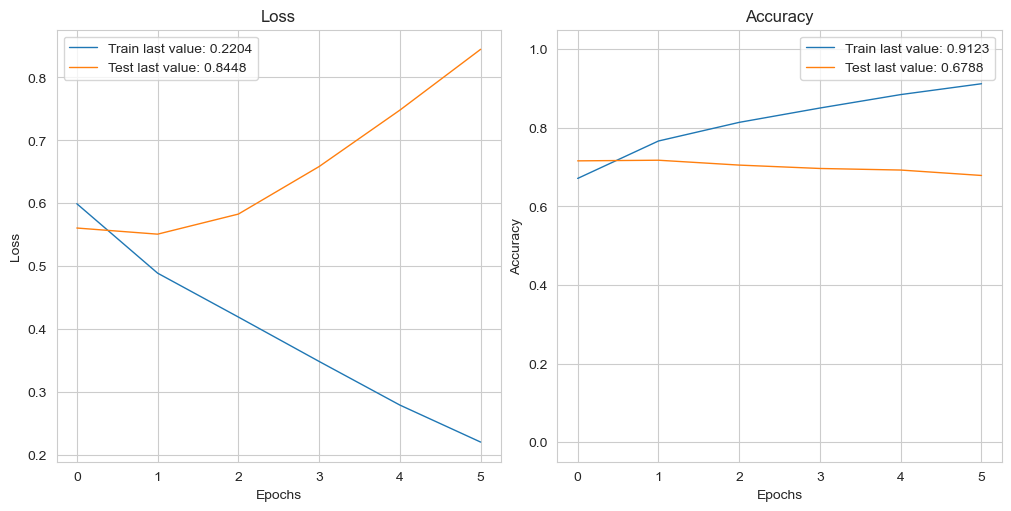

In [91]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt
show_history(history)
#plot_history(history, path="standard.png")
plt.close()

# 4° Modele

In [92]:
X = df["lemmatize_joined"]
y = df['target']

In [93]:
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(X, y , test_size = 0.20)

In [94]:
from tensorflow.keras.preprocessing.text import Tokenizer
vocab_size = 5000
oov_token = "<OOV>"
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

In [95]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [96]:
# pad documents to a max length of 100 words
max_length = 100
padding_type = "post"
trunction_type="post"
X_train_padded = pad_sequences(X_train_sequences,maxlen=max_length, padding=padding_type,
                       truncating=trunction_type)
X_test_padded = pad_sequences(X_test_sequences,maxlen=max_length,
                               padding=padding_type, truncating=trunction_type)

In [ ]:
labels = df['target']
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(df["lemmatize_joined"])
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(df["lemmatize_joined"])
print(encoded_docs)
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

In [98]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400001 word vectors.


In [99]:
embeddings_index.get("paper")

array([-0.85034  ,  0.33358  , -0.65889  , -0.49871  ,  0.36585  ,
       -0.19245  ,  0.25658  , -0.053408 ,  0.31474  ,  0.2443   ,
        0.29337  , -0.44917  ,  0.15175  ,  0.39314  , -0.31786  ,
        0.060525 ,  0.81775  , -0.38847  ,  0.76761  , -1.1041   ,
       -0.1544   ,  0.31655  , -0.37238  , -0.11485  ,  0.51635  ,
       -0.39289  ,  0.16301  , -0.2532   , -0.50976  ,  0.15201  ,
        0.27808  ,  0.52522  , -0.38815  , -0.3472   , -0.61818  ,
        0.17022  ,  0.12251  , -0.24191  , -0.38877  , -0.53176  ,
       -0.46987  , -0.70502  , -0.62126  , -0.38689  , -0.85637  ,
       -0.41003  , -0.47487  , -0.21083  , -0.81338  , -0.52398  ,
        0.49894  ,  0.37909  ,  0.55428  ,  1.123    , -0.42121  ,
       -1.5674   , -0.56892  ,  0.40819  ,  1.7949   ,  0.16856  ,
       -0.0029332,  0.28786  , -0.90088  , -0.094214 ,  0.79993  ,
       -0.39096  ,  0.76286  ,  0.71307  ,  0.13194  , -0.40756  ,
       -0.18687  ,  0.89562  ,  0.46867  , -0.0028801,  0.0253

### Utilisation de GloVe (intégrations de mots pré-entraînées)

In [100]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [101]:
embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=100,
                            weights=[embedding_matrix],
                            input_length=100,
                            trainable=False)

In [104]:
model_c = Sequential([
    embedding_layer,
  Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
  Dense(10, activation='relu'),
  Dense(1, activation='sigmoid')
])

In [105]:
model_c.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [106]:
history = model_c.fit(X_train_padded, y_train, epochs=6, validation_data=(X_test_padded, y_test))

Epoch 1/6
500/500 [==============================] - 29s 56ms/step - loss: 0.6614 - accuracy: 0.5984 - val_loss: 0.6351 - val_accuracy: 0.6190
Epoch 2/6
500/500 [==============================] - 28s 57ms/step - loss: 0.6017 - accuracy: 0.6670 - val_loss: 0.6133 - val_accuracy: 0.6492
Epoch 3/6
500/500 [==============================] - 28s 55ms/step - loss: 0.5377 - accuracy: 0.7246 - val_loss: 0.6171 - val_accuracy: 0.6683
Epoch 4/6
500/500 [==============================] - 32s 63ms/step - loss: 0.4527 - accuracy: 0.7869 - val_loss: 0.7091 - val_accuracy: 0.6245
Epoch 5/6
500/500 [==============================] - 33s 67ms/step - loss: 0.3767 - accuracy: 0.8284 - val_loss: 0.7774 - val_accuracy: 0.6258
Epoch 6/6
500/500 [==============================] - 36s 71ms/step - loss: 0.2920 - accuracy: 0.8731 - val_loss: 0.7714 - val_accuracy: 0.6465


In [107]:
loss, accuracy = model_c.evaluate(X_test_padded,y_test)
print('Testing Accuracy is {} '.format(accuracy*100))

125/125 [==============================] - 3s 22ms/step - loss: 0.7714 - accuracy: 0.6465
Testing Accuracy is 64.64999914169312 


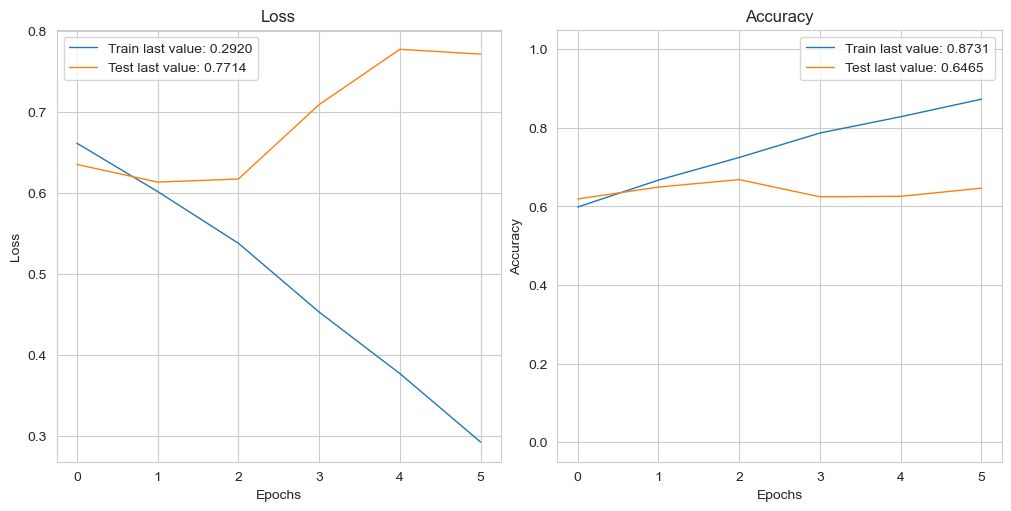

In [108]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history)
plot_history(history, path="standard.png")
plt.close()

### Qu'est-ce qu'une plateforme MLOps ?
#### Une plateforme MLOps offre aux data scientists et aux ingénieurs logiciels un environnement de collaboration qui facilite l'exploration des données par itération, offre des capacités de collaboration en temps réel à des fins de suivi expérimental, d'ingénierie de fonctionnalités et de gestion de modèles. Elle permet également de contrôler la transition, le déploiement et la surveillance des modèles. Une plateforme MLOps automatise les aspects opérationnels et de synchronisation du cycle de vie du machine learning.

## Les grands principes du MLOps
### En se concentrant sur les spécificités inhérentes au MLOps par-dessus les principes DevOps, nous pouvons référencer 5 piliers fondamentaux :
- reproductibilité, 
- déploiement,
- monitoring, 
- gestion du cycle de vie 
- gouvernance.

##### Conclusion : Le MLOps n’est pas qu’une histoire d’outils, ce sont avant tout des comportements